In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../')

from src.emotion.analysis.data_preprocessing import (
    DataPreprocessor,
    LinearInterpolator,
    RollingAverageSmoother,
)

from src.emotion.analysis.feature_generator import FeatureGenerator, VelocityGenerator

%matplotlib inline
pd.set_option('display.max_columns', None)

In [2]:
folder = '/home/moritz/Workspace/masterthesis/data/identities/'
df = pd.read_csv(folder + 'team_20/2023-01-10/team_20_2023-01-10.csv')

In [3]:
feature_pipeline = [VelocityGenerator()]

feature_generator = FeatureGenerator(feature_pipeline)
feature_df = feature_generator.generate_features(df)

feature_df.head()

,Frame,ClassID,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,GazeDetections,Brightness,Velocity
0,0,person_id3,0.805271,417.100403,603.412964,0.001298,0.983145,0.007416,0.005371,0.000224,0.000135,0.002410,[],140.276564,0.000000
1,0,person_id1,0.799670,1092.678223,632.916748,0.002967,0.017306,0.320276,0.019811,0.203477,0.009455,0.426707,[],140.276564,0.000000
2,0,person_id4,0.715621,838.627258,258.571106,0.008836,0.234053,0.020929,0.008893,0.142328,0.002063,0.582898,[],140.276564,0.000000
3,5,person_id3,0.807259,417.817810,603.769714,0.001241,0.953628,0.022795,0.016446,0.000363,0.000268,0.005258,[],140.308587,2.010950
4,5,person_id1,0.804896,1092.973022,633.406616,0.003357,0.026146,0.469920,0.021953,0.121223,0.011890,0.345511,[],140.308587,0.601794


In [4]:

# TODO: Only compute derivatives, when consecutive frames are less than 10 frame apart!
preprocessing_pipeline = [
        LinearInterpolator(),
        RollingAverageSmoother(window_size=5, cols=["Velocity"]),
    ]

preprocessor = DataPreprocessor(preprocessing_pipeline)
pre_df = preprocessor.preprocess_data(feature_df)

pre_df.head()

,Frame,Confidence,x_center,y_center,Angry,Disgust,Happy,Sad,Surprise,Fear,Neutral,Brightness,Velocity,ClassID
0,0,0.799670,1092.678223,632.916748,0.002967,0.017306,0.320276,0.019811,0.203477,0.009455,0.426707,140.276564,0.120359,person_id1
1,1,0.800715,1092.737183,633.014722,0.003045,0.019074,0.350205,0.020240,0.187026,0.009942,0.410468,140.282968,0.180538,person_id1
2,2,0.801760,1092.796143,633.112695,0.003123,0.020842,0.380134,0.020668,0.170575,0.010429,0.394229,140.289373,0.240718,person_id1
3,3,0.802805,1092.855103,633.210669,0.003201,0.022610,0.410063,0.021096,0.154124,0.010916,0.377990,140.295777,0.361077,person_id1
4,4,0.803851,1092.914062,633.308643,0.003279,0.024378,0.439992,0.021524,0.137674,0.011403,0.361751,140.302182,0.466952,person_id1


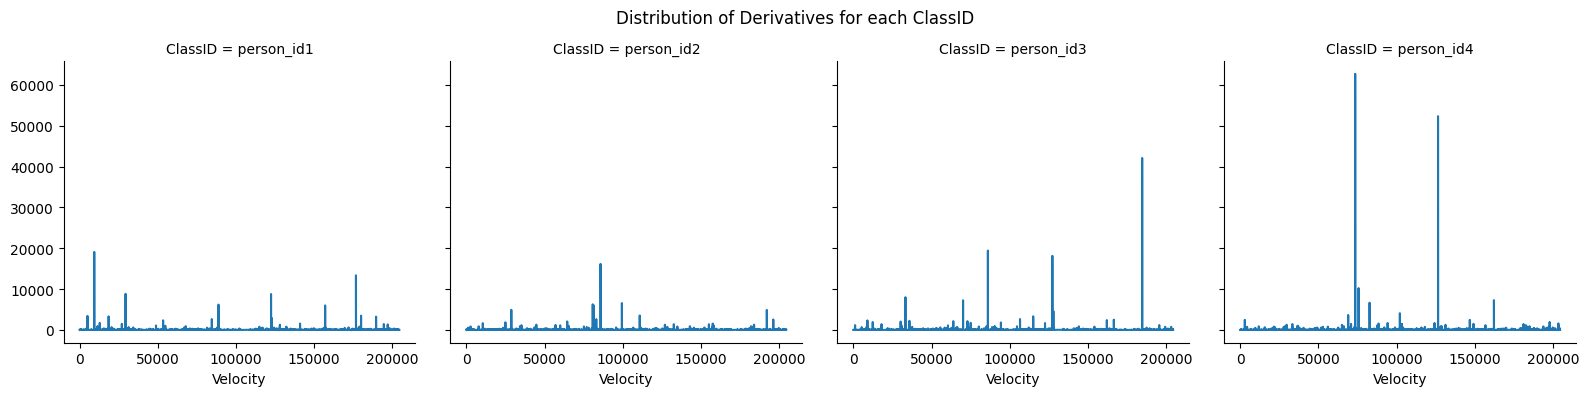

In [5]:
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=True)
g.map(plt.plot, 'Velocity')

# Set the plot properties
plt.subplots_adjust(wspace=0.1, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

# Show the plot
plt.show()

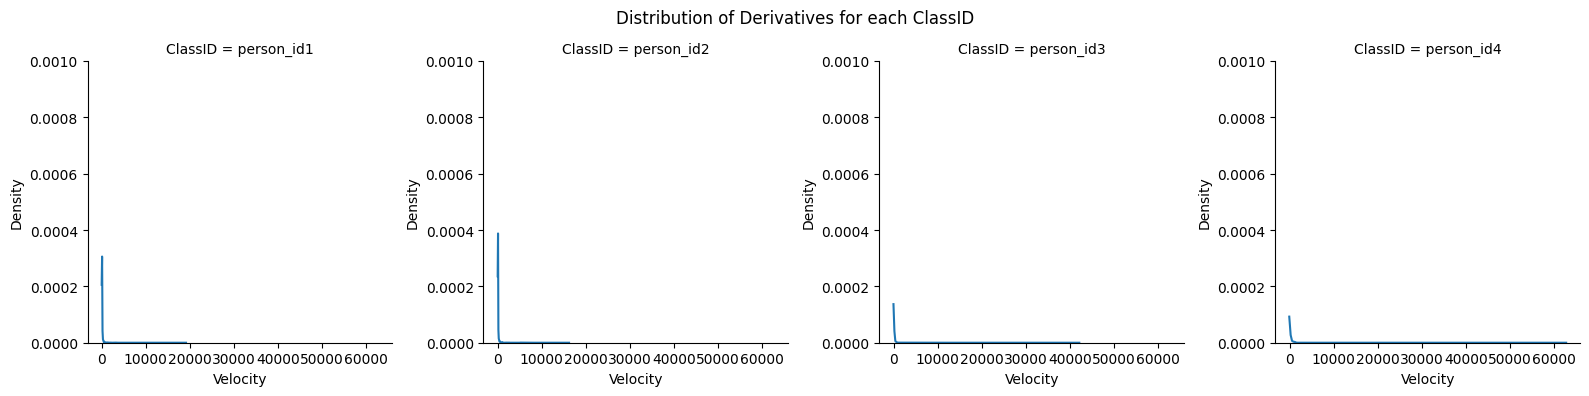

In [6]:
# TODO: Standard Normalization seems appropriate, but should we use the whole cohort as reference?
# Create the FacetGrid
g = sns.FacetGrid(data=pre_df, col='ClassID', col_wrap=4, height=4, sharey=False, sharex=True, ylim=(0, 0.001))
g.map(sns.kdeplot, 'Velocity')

plt.subplots_adjust(wspace=0.3, top=0.85)
g.fig.suptitle('Distribution of Derivatives for each ClassID')

plt.show()

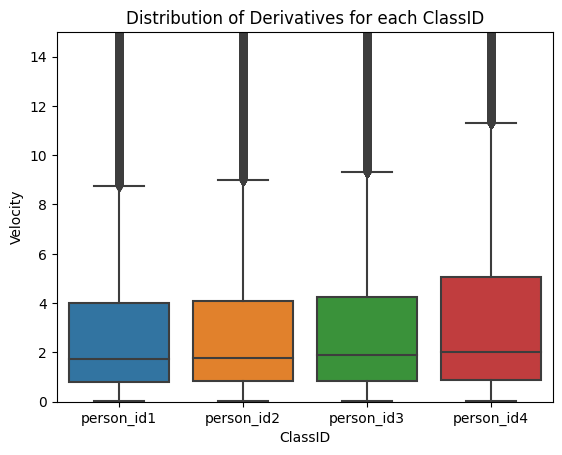

In [7]:
# Boxplot
sns.boxplot(data=pre_df, x='ClassID', y='Velocity')

plt.title('Distribution of Derivatives for each ClassID')
# Note, that we are cutting off some outliers here
plt.ylim(0, 15)

plt.show()